# 18HEUR - GA for training ANN

### Miroslav Kubů

email: kubumiro@fjfi.cvut.cz

# Goal

<ul>
    <li>build artificial neural network</li>
    <li>train artificial neural network using genetic algorithm </li>
    <li> measure the performance of the classification by fitness value </li>
    <li> compare the results for various parameter settings </li>
    <li> choose the optimal parameter settings based on the best mean fitness value </li>
</ul>


# IRIS Dataset for Binary Classification Task

In [1]:
#import GA 
#import AN 

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

We use IRIS training dataset for two classes. The matching inputs are stored in the first 100 observations. Then, we want to perform a statistical binary classification task using an ANN.

In [2]:
iris = datasets.load_iris()
X= iris.data[:100, :] #input
Y = iris.target[:100] #target

In [3]:
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# AN.py

In [4]:
import numpy as np

For the ANN model prediction, we firstly define the activation functions. In our case, we can use ReLU activation function for hidden layers.

\begin{equation}
    \textrm{ReLU} (x) = \begin{cases}
    x &\mbox{if } x \geq 0 \\
    0 & \mbox{if } x <  0 \end{cases}.
\end{equation}

For the output layer, the sigmoid activation function is used. We can use sigmoid function for hidden layers as well.

\begin{equation}
f(x) = \frac{1}{1+e^{-x}}.
\end{equation}

The output of sigmoid can be later interpreted as the probability of an input belonging to the first class.

In [5]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-1 * x))

def relu(x):
    result = x
    result[x < 0] = 0
    return result

Within the `predict_outputs` function, we calculate the ANN predictions as well as overall accuracy

\begin{equation}
    ACC = \frac{\#\textrm{correctly predicted}}{\#\textrm{total}}.
\end{equation}

The idea of this function is using matrix multiplication of an input with the weights of each layer and then transform it with the activation function. In addition to ACC, we also observe the mean squared error (MSE) loss function defined as

\begin{equation}
L(y,\hat{y})=(y-\hat{y})^2,
\end{equation}
where $y$ is a labeled output and $\hat{y}$ is the predicted output. Thus, MSE serves as the more precise measure of the performance compared to ACC.

In [6]:
def predict_outputs(weights_mat, inputs, outputs, activation="relu"):
    Y_pred = np.zeros(shape=(inputs.shape[0]))
    Y_prob = np.zeros(shape=(inputs.shape[0]))
    for i in range(inputs.shape[0]):
        x = inputs[i, :]
        for curr_weights in weights_mat:
            x = np.matmul(x, curr_weights)
            if activation == "relu":
                x = relu(x)
            elif activation == "sigmoid":
                x = sigmoid(x)
      
    #output of sigmoid function > 0.5 ---> input is considered as class 1 with prob. > 0.5
    
        if x>0.5: 
            predicted_label =1
        else:
            predicted_label=0
        Y_prob[i] = x
        Y_pred[i] = predicted_label
    correct = np.where(Y_pred == outputs)[0].size
    accuracy = (correct / outputs.size) * 100   #acc
    loss = np.sum(np.square(Y-Y_prob))    #mse 
    return accuracy, Y_pred, Y_prob, loss

# GA.py


In [7]:
import numpy as np
import random

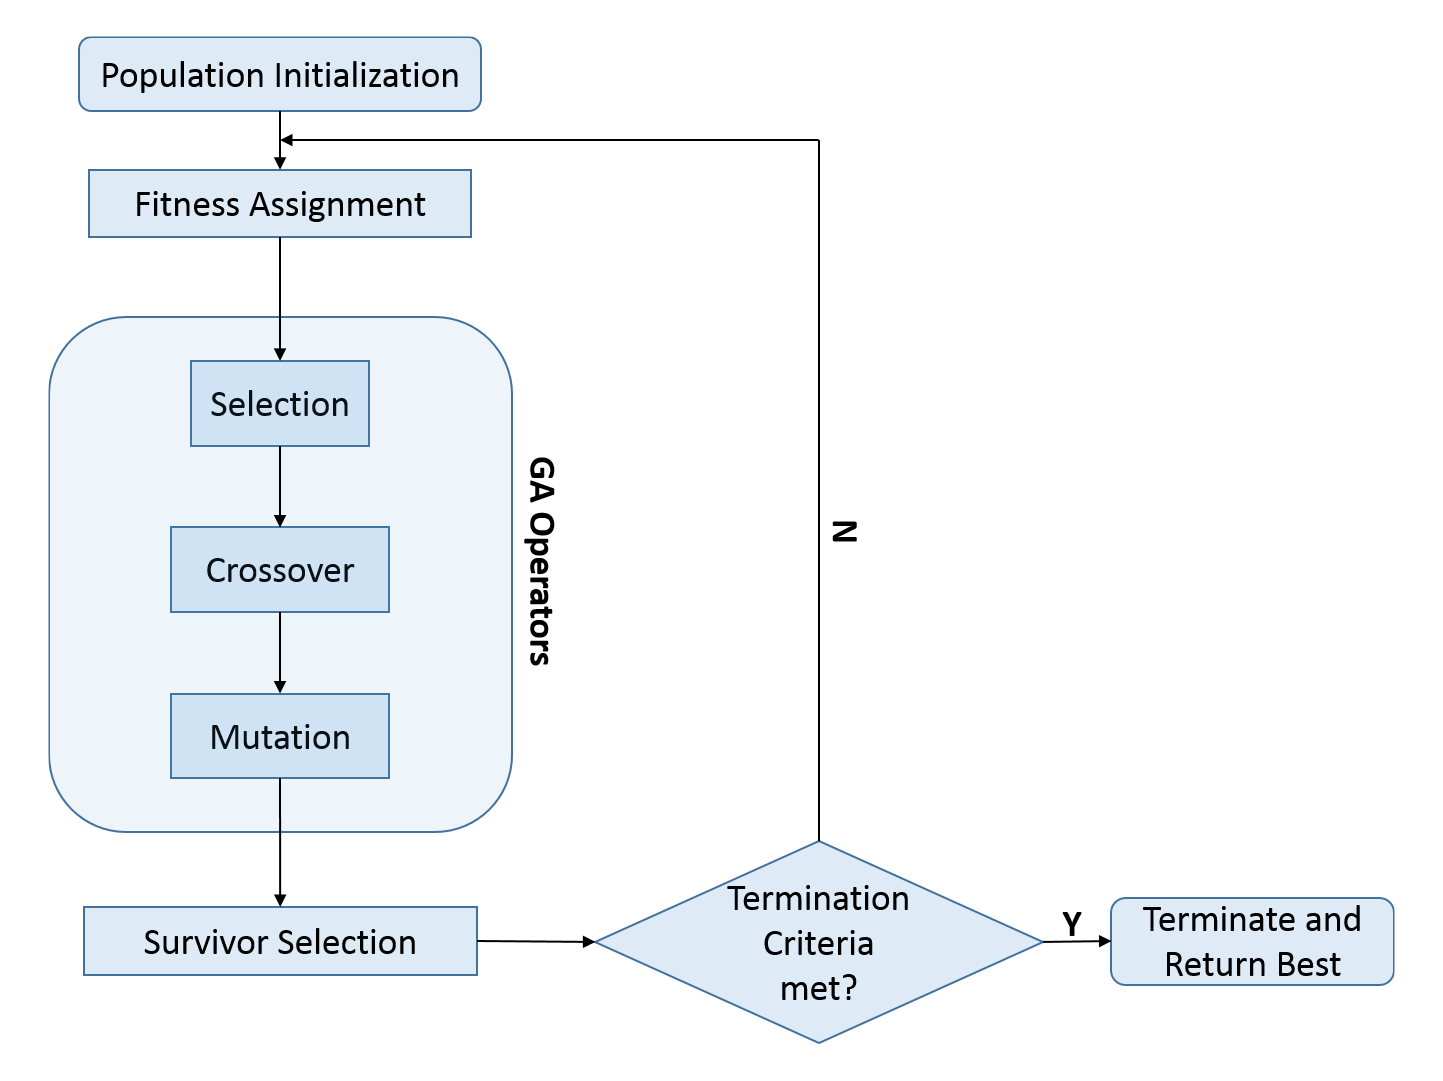

In [8]:
from IPython.display import Image
Image("ga.png")

We peform the genetic optimization algorithm according to the scheme above (picture taken from [3]). Because the matrix multiplication is used within ANN, we will still represent the ANN parameters in the matrix form when using the ANN. However we are used to perform GA operations with a 1D vector. Thus, matrix form is used when working with the ANN and vector form is used when working with GA. That´s why we define functions for conversion between matrix and vector form.

In [9]:
def mat_to_vector(matrix_weights):
    weights_vector = []
    for i in range(matrix_weights.shape[0]): #runs through solutions in population
        curr_vector = []
        for layer_i in range(matrix_weights.shape[1]): #runs through layers in solution
            vector_weights = np.reshape(matrix_weights[i, layer_i], newshape=(matrix_weights[i, layer_i].size))
            curr_vector.extend(vector_weights)
        weights_vector.append(curr_vector)
    return np.array(weights_vector)

def vector_to_mat(vector_weights, matrix_weights):
    mat_weights = []
    for i in range(matrix_weights.shape[0]):  #runs through solutions in population
        start = 0
        end = 0
        for layer_i in range(matrix_weights.shape[1]): #runs through layers in solution
            end = end + matrix_weights[i, layer_i].size
            curr_vector = vector_weights[i, start:end]
            mat_layer_weights = np.reshape(curr_vector, newshape=(matrix_weights[i, layer_i].shape))
            mat_weights.append(mat_layer_weights)
            start = end
    return np.reshape(mat_weights, newshape=matrix_weights.shape)

GA needs to return a fitness value for each solution. We select the MSE as the selected fitness value. Thus, a low fitness value leads to a better solution. We can use ACC as the fitness value as well, but the MSE measure is more precise.

As the output of `fitness_pop` is basically an accuracy and MSE for selected weights, we use the `predict_outputs` function.

In [10]:
def fitness_pop(weights_matrix, inputs, outputs, activation="relu"): 
    accuracy = np.empty(shape=(weights_matrix.shape[0]))
    loss = np.empty(shape=(weights_matrix.shape[0]))

    for i in range(weights_matrix.shape[0]): #runs through solutions in population
        pom_mat = weights_matrix[i, :]
        accuracy[i], _ , _, loss[i] = predict_outputs(pom_mat, inputs, outputs, activation=activation)
    return accuracy,loss

We choose the best `num_parents` parents for following crossover within the `select_mating_pool` function.

In [11]:
def select_mating_pool(pop, fitness, num_parents):
    parents = np.empty((num_parents, pop.shape[1]))
    for parent_i in range(num_parents): 
        max_fitness_i = np.where(fitness == np.min(fitness)) #runs through solutions in population
        max_fitness_i = max_fitness_i[0][0]
        parents[parent_i, :] = pop[max_fitness_i, :]
        fitness[max_fitness_i] = 999999 # so that we won't use this parent again
    return parents

Then, we perform `crossover` between selected parents. We choose the number of offsprings in `offspring_size`. After we choose fitting `parent1` and `parent2`, we use `cross_percent` % of `parent1` genes for the offspring (crossover rate $c$).

In [12]:
def crossover(parents, offspring_size,cross_percent):
    offspring = np.empty(offspring_size)
    crossover_point = np.uint8(offspring_size[1]*cross_percent/100)
    for k in range(offspring_size[0]):
        
        #using modulo, we choose a sequence of parents to mate
        parent1_i = k%parents.shape[0] #first parent to mate
        parent2_i = (k+1)%parents.shape[0] #second parent to mate.
        
        offspring[k, 0:crossover_point] = parents[parent1_i, 0:crossover_point] 
        offspring[k, crossover_point:] = parents[parent2_i, crossover_point:] # ]rest of the genes is taken from the 2nd parent
        
    return offspring

In addition to crossover, we perform offspring `mutation` by changing `mutation_percent` % of its chromosomes (mutation rate $m$). We use random uniform number for randomly changing the chromosomes.

In [13]:
def mutation(offspring_mutation, mutation_percent):
    #numb. of chromosomes mutated
    num_mutations = np.uint8((mutation_percent*offspring_mutation.shape[1])/100) 
    
    # randomly selected indices for offspring mutation.
    mutation_indices = np.array(random.sample(range(0, offspring_mutation.shape[1]), num_mutations))
    
    # mutation changes a single gene in each offspring randomly.
    for i in range(offspring_mutation.shape[0]):
        rand_numb = np.random.uniform(-1.0, 1.0, 1) # random number to be added to the gene.
        offspring_mutation[i, mutation_indices] = offspring_mutation[i, mutation_indices] + rand_numb
    return offspring_mutation

# Main file

### Genetic algorithm parameters:

We can set the initial parameters for GA. 

1.    Number of parents in mating pool
2.    Number of generations
3.    Mutation percent
4.    Crossover ratio
5.    Number of solutions per population (cardinality of each generation)

In [14]:
num_parents_mating = 4
num_generations = 50
mutation_percent = 10
cross_percent = 60
sol_per_pop = 10

### ANN Architecture

We use a fixed ANN architecture so that we can later compare various GA parameter settings.

1. layer 1 ... 10 neurons
2. layer 2 ... 10 neurons
3. output layer ... 1 output neuron

Uniform distribution $U(0,1)$ is used for weight initialization. 


\begin{equation}
w \sim U(-0.1,0.1).
\end{equation}


In the following step, we set the initial weights (population in terms of GA) for each layer.

In [15]:
def createNN():


    initial_pop_weights = []
    data_inputs=X
    data_outputs=Y


    for solution in np.arange(0, sol_per_pop): #runs through solutions in population
        HL1_neurons = 10 #neurons in 1st hidden layer
        input_HL1_weights = np.random.uniform(low=-0.1, high=0.1, size=(data_inputs.shape[1], HL1_neurons))

        HL2_neurons = 10 #neurons in 2nd hidden layer
        HL1_HL2_weights = np.random.uniform(low=-0.1, high=0.1, size=(HL1_neurons, HL2_neurons))

        output_neurons = 1 #neurons in the output layer
        HL2_output_weights = np.random.uniform(low=-0.1, high=0.1, size=(HL2_neurons, output_neurons))

        initial_pop_weights.append(np.array([input_HL1_weights, HL1_HL2_weights, HL2_output_weights]))

### Main algorithm

Within the main algorithm, we perform following operations for each generation

1. evaluate fitness  
2. select mating pool 
3. do the crossover  
4. perform mutation 
5. settle new generation


Each solution includes the weights from each layer of the model. By default, `sol_per_pop`=10 solutions are observed for each generation. Otherwise, `mat_to_vector` and `vector_to_mat` functions are used frequently, as we need to flatten weights into vectors for each generation. The algorithm terminates if there are no more generations left. Function GO creates the ANN model and then performs the genetic optimization for selected number of solutions per population, crossover percentage and mutation percentage.


In [16]:
def GO(X,Y,sol_per_pop, cross_percent, mutation_percent):
    
    initial_pop_weights = []
    data_inputs=X
    data_outputs=Y


    for solution in np.arange(0, sol_per_pop): #runs through solutions in population
        HL1_neurons = 10 #neurons in 1st hidden layer
        input_HL1_weights = np.random.uniform(low=-0.1, high=0.1, size=(data_inputs.shape[1], HL1_neurons))

        HL2_neurons = 10 #neurons in 2nd hidden layer
        HL1_HL2_weights = np.random.uniform(low=-0.1, high=0.1, size=(HL1_neurons, HL2_neurons))

        output_neurons = 1 #neurons in the output layer
        HL2_output_weights = np.random.uniform(low=-0.1, high=0.1, size=(HL2_neurons, output_neurons))

        initial_pop_weights.append(np.array([input_HL1_weights, HL1_HL2_weights, HL2_output_weights]))

    

    pop_weights_mat = np.array(initial_pop_weights)
    pop_weights_vector = mat_to_vector(pop_weights_mat)

    best_outputs = []
    accuracies = np.empty(shape=(num_generations))
    loss = np.empty(shape=(num_generations))

    for generation in range(num_generations):


        pop_weights_mat = vector_to_mat(pop_weights_vector, pop_weights_mat)


        # fitness of population (for each solution)
        fit_accuracy, fit_loss = fitness_pop(pop_weights_mat, data_inputs, data_outputs,  activation="sigmoid")    
        parents = select_mating_pool(pop_weights_vector, fit_loss.copy(), num_parents_mating)

        # append new offsprings to selected parents (we keep the same number of solutions per pop.)
        offspring_crossover = crossover(parents,offspring_size=(pop_weights_vector.shape[0]-parents.shape[0], 
                                                                pop_weights_vector.shape[1]),cross_percent=cross_percent)
        offspring_mutation = mutation(offspring_crossover, mutation_percent=mutation_percent)


        # new population 
        pop_weights_vector[0:parents.shape[0], :] = parents
        pop_weights_vector[parents.shape[0]:, :] = offspring_mutation

        pop_weights_mat = vector_to_mat(pop_weights_vector, pop_weights_mat)

        #Use weights for prediction and accuracy of current generation
        weights_current = pop_weights_mat [0, :]
        accuracies[generation],_,_,loss[generation] = predict_outputs(weights_current, data_inputs, data_outputs, activation="sigmoid")



    pop_weights_mat = vector_to_mat(pop_weights_vector, pop_weights_mat)

    #Use best weights for final prediction
    best_weights = pop_weights_mat [0, :]
    acc, predictions, probs, mse_loss = predict_outputs(best_weights, data_inputs, data_outputs, activation="sigmoid")
    return acc, mse_loss

## Tuning mutation rate $m$ and crossover point $c$ parameters

Inspired by Ettaouil [2], we perform the GO with different crossover and mutation parameters and then compare the results for different parameters. The best settings lead to the smallest fitness value after fixed number of epochs.  

In [29]:
import pandas as pd
results = pd.DataFrame()
maxruns = 50 # we run every parameter settings 50x to calculate a mean fitness value
res = np.empty([4,10])

for cross_percent in range(20,100,20):
    for mutation_percent in range(5,55,5):
        mse = np.empty(maxruns)
        for run in range(0,maxruns):
            _,mse[run] = GO(X,Y,sol_per_pop, cross_percent, mutation_percent)
        mean_loss = np.mean(mse)
        var_loss = np.var(mse)
        i = int(cross_percent/20-1)
        j = int(mutation_percent/5-1)
        res[i,j] = round(mean_loss,4)
        print('Crossover perc.:',cross_percent,'  Mutation perc.:',mutation_percent,'  Mean fitness value:',res[i,j])

print('Best avverage fitness value is',np.min(res))        

Crossover perc.: 20   Mutation perc.: 5   Mean fitness value: 17.7727
Crossover perc.: 20   Mutation perc.: 10   Mean fitness value: 14.8803
Crossover perc.: 20   Mutation perc.: 15   Mean fitness value: 16.744
Crossover perc.: 20   Mutation perc.: 20   Mean fitness value: 19.7788
Crossover perc.: 20   Mutation perc.: 25   Mean fitness value: 21.8613
Crossover perc.: 20   Mutation perc.: 30   Mean fitness value: 24.0662
Crossover perc.: 20   Mutation perc.: 35   Mean fitness value: 24.648
Crossover perc.: 20   Mutation perc.: 40   Mean fitness value: 24.8962
Crossover perc.: 20   Mutation perc.: 45   Mean fitness value: 24.9671
Crossover perc.: 20   Mutation perc.: 50   Mean fitness value: 24.9963
Crossover perc.: 40   Mutation perc.: 5   Mean fitness value: 17.5086
Crossover perc.: 40   Mutation perc.: 10   Mean fitness value: 15.9243
Crossover perc.: 40   Mutation perc.: 15   Mean fitness value: 17.3663
Crossover perc.: 40   Mutation perc.: 20   Mean fitness value: 19.5029
Crossover 

In [64]:
res

array([[17.7727, 14.8803, 16.744 , 19.7788, 21.8613, 24.0662, 24.648 ,
        24.8962, 24.9671, 24.9963],
       [17.5086, 15.9243, 17.3663, 19.5029, 22.4862, 23.4787, 23.749 ,
        24.9832, 24.9951, 24.9935],
       [17.0552, 15.2263, 17.0053, 21.2815, 21.8832, 24.1969, 24.4683,
        24.983 , 24.9942, 24.9966],
       [16.6415, 16.9192, 16.4295, 19.9958, 21.302 , 24.4392, 24.7654,
        24.9092, 24.988 , 24.9928]])

In [30]:
np.savetxt("res_mean.csv", res)
np.savetxt("res_var.csv", res_var)

We observe the GO performance 50 times for each parameter settings to form corresponding statistic for fitness values (loss functions). The table below shows mean fitness values for different parameter settings. A lower fitness value means a lower classification error.

| Parameters  | $c=$ $20\%$ | $c=$ $40\%$ | $c=$ $60\%$ |$c=$ $80\%$ |
|:---|--------------------------|--------------------------|--------------------------|--------------------------|
|$m =5\%$| 17.7727 | 17.5086 | 17.0551 | 16.6415 |
|$m =10\%$| 14.8803 | 15.9243 | 15.2263 | 16.9192 |
|$m =15\%$| 16.7439 | 17.3662 | 17.0052 | 16.4295 |
|$m =20\%$| 19.7788 | 19.5029 | 21.2815 | 19.9957 |
|$m =25\%$| 21.8612 | 22.4862 | 21.8831 | 21.3019 |
|$m =30\%$| 24.0661 | 23.4786 | 24.1968 | 24.4391 |
|$m =35\%$| 24.6479 | 23.7489 | 24.4682 | 24.7653 |
|$m =40\%$| 24.8962 | 24.9832 | 24.9830 | 24.9091 |
|$m =45\%$| 24.9671 | 24.9951 | 24.9941 | 24.9879 |
|$m =50\%$| 24.9963 | 24.9935 | 24.9966 | 24.9927 |


As the table above shows, the smallest average fitness value FV = 14.8803 corresponds to the 10% mutation rate and 20% crossover rate. Made by https://www.tablesgenerator.com/markdown_tables#.

In [48]:
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

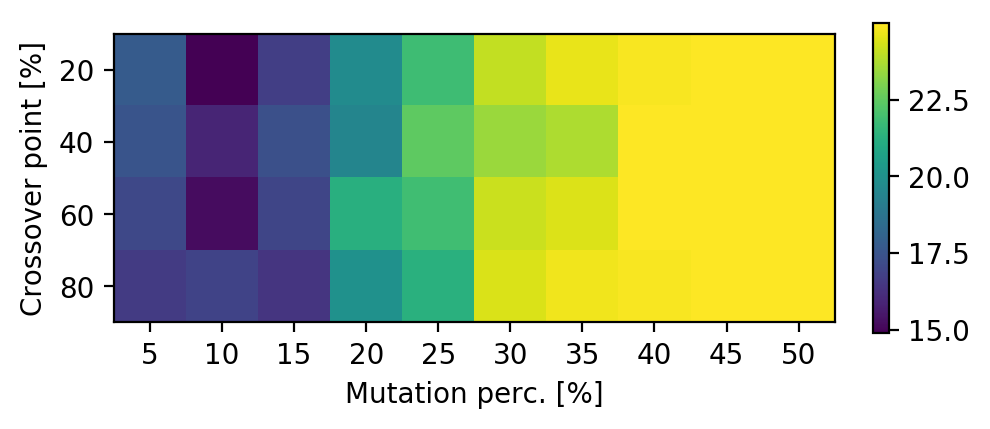

In [62]:
im = plt.imshow(res, interpolation='nearest')
plt.xticks(np.arange(10), ('5', '10', '15', '20', '25','30','35','40','45','50'))
plt.yticks(np.arange(4), ('20', '40', '60', '80'))
plt.ylabel('Crossover point [%]')
plt.xlabel('Mutation perc. [%]')
plt.colorbar(im,fraction=0.02)
plt.show()

The picture above shows the fitness values illustrated via pixelmap with pixel intesities corresponding to the fitness values. As mentioned, the best results are observed near the 10% mutation rate boundary. GO with mutation rate over 30% performed significantly worse. This shows that while the crossover rate change did not lead to significant change in performance, mutation rate can significantly influence the performance of the classifier.

# Conclusion

<ul>
    <li> we successfully trained our ANN on IRIS training dataset</li>
    <li> the classification performance was measured in MSE fitness value</li>
    <li> we sucessfully trained various models with different mutation rate $m$ and crossover $c$ parameters settings</li>
    <li> the smallest error was observed with: </li>
        - $m = 10 \%$, $c = 20 \%$
    <li> mutation rate had a more significant effect on the performance than crossover rate </li>
    <li> generally, we observed the best results for mutation rate $m \approx 10 \%$ </li>
    <li> performance for $m > 30 \%$ rapidly decreased </li>
    
    
   

</ul>

# Literature

[1] Petra Vidnerová, Roman Neruda. Evolution Strategies for Deep Neural Network Models Design J. ITAT 2017 Proceedings, pp. 159–166.

[2] Mohamed Ettaouil, Youssef Ghanou. Neural architectures optimization and genetic algorithms. Journal of WSEAS Transactions on Computers archive, Volume 8 Issue 3, March 2009, pp. 526-537. 

[3]  Anand Deshpande, Manish Kumar. Artificial Intelligence for Big Data. Packt. May 2018. 